<a href="https://colab.research.google.com/github/angomoson/pytorch/blob/main/1_NMT_Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Gathering and Processing

To build a Machine Translation system, you need bilingual data, i.e. source sentences and their translations. You can use public bilingual corpora/datasets or you can use your translation memories (TMs). However, NMT requires a lot of data to train a good model, that is why most companies start with training a strong baseline model using public bilingual datasets, and then fine-tune this baseline model on their TMs. Sometimes also you can use pre-trained models directly for fine-tuning.

The majority of public bilingual datasets are collected on OPUS: https://opus.nlpl.eu/

Most of the datasets can be used for both commercial and non-commercial uses; however, some of them have more restricted licences. So you have to double-check the licence of a dataset before using it.

On OPUS, go to “Search & download resources” and choose two languages from the drop-down lists. You will see how it will list the available language datasets for this language pair. Try to use non-variant language codes like “en” for English and “fr” for French to get all the variants under this language. To know more details about a specific dataset, click its name.

In Machine Translation, we use the “Moses” format. Go ahead and try to download the “tico-19 v2020-10-28” by clicking “moses”. This will download a *.zip file; when you extract it, the two files that you care about are those whose names ending by the language codes. For example, for English to French, you will have “tico-19.en-fr.en” and “tico-19.en-fr.fr“. You can open these files with any text editor. Each file has a sentence/segment per line, and it is matching translation in the same line in the other file. This is what the "Moses" file format means.

Note that not all datasets are of the same quality. Some datasets have lower quality, especially big corpora crawled from the web. Check the provided “sample” before using the dataset. Nevertheless, even high-quality datasets, like those from the UN and EU, require filtering.



In [1]:
# Create a directory and clone the Github MT-Preparation repository
!mkdir -p nmt
%cd nmt
!git clone https://github.com/ymoslem/MT-Preparation.git

/content/nmt
Cloning into 'MT-Preparation'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 268 (delta 133), reused 189 (delta 97), pack-reused 0
Receiving objects: 100% (268/268), 69.06 KiB | 3.84 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [2]:
# Install the requirements
!pip3 install -r MT-Preparation/requirements.txt

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
%cd nmt-data/training-data

[Errno 2] No such file or directory: 'nmt-data/training-data'
/content/nmt


In [31]:
%ls

MT-Preparation/  source.model  source.vocab  target.model  target.vocab


In [19]:
%cd /content/nmt/

/content/nmt


In [7]:
%cd /content/drive/MyDrive/nmt-data/training-data

/content/drive/MyDrive/nmt-data/training-data


In [10]:
%cp /content/drive/MyDrive/nmt-data/training-data/french.fr /content/nmt/MT-Preparation

In [33]:
%cp /content/drive/MyDrive/nmt-data/validation/english.valid.en /content/nmt/MT-Preparation

# Data Filtering

Filtering out low-quality segments can help improve the translation quality of the output MT model. This might include misalignments, empty segments, duplicates, among other issues.

In [22]:
# Filter the dataset
# Arguments: source file, target file, source language, target language
!python3 MT-Preparation/filtering/filter.py MT-Preparation/french.fr MT-Preparation/english.en fr en

Dataframe shape (rows, columns): (10000, 2)
--- Rows with Empty Cells Deleted	--> Rows: 9980
--- Duplicates Deleted			--> Rows: 9899
--- Source-Copied Rows Deleted		--> Rows: 9896
--- Too Long Source/Target Deleted	--> Rows: 9824
--- HTML Removed			--> Rows: 9824
--- Rows will remain in true-cased	--> Rows: 9824
--- Rows with Empty Cells Deleted	--> Rows: 9824
--- Rows Shuffled			--> Rows: 9824
--- Source Saved: MT-Preparation/french.fr-filtered.fr
--- Target Saved: MT-Preparation/english.en-filtered.en


In [34]:
# Filter the dataset
# Arguments: source file, target file, source language, target language
!python3 MT-Preparation/filtering/filter.py MT-Preparation/french.valid.fr MT-Preparation/english.valid.en fr en

Dataframe shape (rows, columns): (201, 2)
--- Rows with Empty Cells Deleted	--> Rows: 201
--- Duplicates Deleted			--> Rows: 201
--- Source-Copied Rows Deleted		--> Rows: 201
--- Too Long Source/Target Deleted	--> Rows: 198
--- HTML Removed			--> Rows: 198
--- Rows will remain in true-cased	--> Rows: 198
--- Rows with Empty Cells Deleted	--> Rows: 198
--- Rows Shuffled			--> Rows: 198
--- Source Saved: MT-Preparation/french.valid.fr-filtered.fr
--- Target Saved: MT-Preparation/english.valid.en-filtered.en


# Tokenization / Sub-wording

To build a vocabulary for any NLP model, you have to tokenize (i.e. split) sentences into smaller units. Word-based tokenization used to be the way to go; in this case, each word would be a token. However, an MT model can only learn a specific number of vocabulary tokens due to limited hardware resources. To solve this issue, sub-words are used instead of whole words. At translation time, when the model sees a new word/token that looks like a word/token it has in the vocabulary, it still can try to continue the translation instead of marking this word as “unknown” or “unk”.

There are a few approaches to sub-wording such as BPE and the unigram model. One of the famous toolkits that incorporates the most common approaches is [SentencePiece](https://github.com/google/sentencepiece). Note that you have to train a sub-wording model and then use it. After translation, you will have to “desubword” or “decode” your text back using the same SentencePiece model.



In [23]:
!ls MT-Preparation/subwording/

1-train_bpe.py	1-train_unigram.py  2-subword.py  3-desubword.py


In [36]:
# Train a SentencePiece model for subword tokenization
!python3 MT-Preparation/subwording/1-train_bpe.py MT-Preparation/french.fr-filtered.fr MT-Preparation/english.en-filtered.en

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=MT-Preparation/french.fr-filtered.fr --model_prefix=source --vocab_size=50000 --hard_vocab_limit=false --model_type=bpe --split_digits=true
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: MT-Preparation/french.fr-filtered.fr
  input_format: 
  model_prefix: source
  model_type: BPE
  vocab_size: 50000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 0
  use

In [37]:
!ls

MT-Preparation	source.model  source.vocab  target.model  target.vocab


In [38]:
# Subword the dataset
!python3 MT-Preparation/subwording/2-subword.py source.model target.model MT-Preparation/french.valid.fr-filtered.fr MT-Preparation/english.valid.en-filtered.en

Source Model: source.model
Target Model: target.model
Source Dataset: MT-Preparation/french.valid.fr-filtered.fr
Target Dataset: MT-Preparation/english.valid.en-filtered.en
Done subwording the source file! Output: MT-Preparation/french.valid.fr-filtered.fr.subword
Done subwording the target file! Output: MT-Preparation/english.valid.en-filtered.en.subword


In [28]:
# First 3 lines before subwording
!head -n 3 MT-Preparation/french.fr-filtered.fr && echo "-----" && head -n 3 MT-Preparation/english.en-filtered.en

J'espère sincèrement que, dans l'intérêt de l'amélioration de la sécurité et de la qualité de vie des populations de cette région, les principaux protagonistes vont progresser rapidement, dans un avenir tout proche, vers l'obtention d'un accord global sur toutes les grandes questions qu'il faut résoudre.
Il faut mettre fin à la situation actuelle, dans laquelle les organisations financièrement puissantes disposant de représentants à Bruxelles ont accès à des informations dont sont privés les simples citoyens.
Madame la Présidente, chers collègues, je voudrais tout d'abord établir très clairement la chose suivante : il n'y a pas de danger, en Autriche, de résurgence d'un système de parti unique ou d'un système totalitaire de droite.
-----
I sincerely hope that, in the interests of improving the safety and quality of life of the people living in the Middle East, all the key protagonists will move forward quickly, in the very near future, so as to reach an overall agreement on all the key

In [39]:
# First 3 lines before subwording
!head -n 3 MT-Preparation/french.valid.fr-filtered.fr && echo "-----" && head -n 3 MT-Preparation/english.valid.en-filtered.en

En tant que front entre la sphère d'influence russe et le fondamentalisme islamiste en Afghanistan, les chances de survie de l'État tadjik sont minces.
Cette aide financière sous forme de prêt ne devrait toutefois être accordée qu' à plusieurs conditions : qu' un contrôle en règle de l' aide financière puisse effectivement être réalisé par l' Union européenne, que le processus de réconciliation nationale se poursuive et que les élections, et surtout les élections législatives de mars 2000, soient organisées librement et démocratiquement.
Certains présidents obtiennent une prolongation de dix ans de leur mandat à l'aide de référendums et d'intimidations, sans qu'il ne puisse y avoir de candidat d'opposition.
-----
As a frontline area flanked, on the one hand, by the Russian sphere of influence and, on the other hand, by Islamic fundamentalism in Afghanistan, the present Tajikistani State has little chance of survival.
However, the financial aid in the form of loans should only be grante

In [40]:
# First 3 lines after subwording
!head -n 3 MT-Preparation/french.valid.fr-filtered.fr.subword && echo "-----" && head -n 3 MT-Preparation/english.valid.en-filtered.en.subword

▁En ▁tant ▁que ▁front ▁entre ▁la ▁sphère ▁d ' influence ▁russe ▁et ▁le ▁fondament alisme ▁is lam iste ▁en ▁Af gh an istan , ▁les ▁chances ▁de ▁survie ▁de ▁l ' État ▁t adjik ▁sont ▁minces .
▁Cette ▁aide ▁financière ▁sous ▁forme ▁de ▁prêt ▁ne ▁devrait ▁toutefois ▁être ▁accordée ▁qu ' ▁à ▁plusieurs ▁conditions ▁: ▁qu ' ▁un ▁contrôle ▁en ▁règle ▁de ▁l ' ▁aide ▁financière ▁puisse ▁effectivement ▁être ▁réalisé ▁par ▁l ' ▁Union ▁européenne , ▁que ▁le ▁processus ▁de ▁réconciliation ▁nationale ▁se ▁poursuive ▁et ▁que ▁les ▁élections , ▁et ▁surtout ▁les ▁élections ▁législatives ▁de ▁mars ▁ 2 0 0 0 , ▁soient ▁organis ées ▁librement ▁et ▁démocratique ment .
▁Certains ▁présidents ▁obtiennent ▁une ▁prolongation ▁de ▁dix ▁ans ▁de ▁leur ▁mandat ▁à ▁l ' aide ▁de ▁référen dums ▁et ▁d ' inti midations , ▁sans ▁qu ' il ▁ne ▁puisse ▁y ▁avoir ▁de ▁candidat ▁d ' opposition .
-----
▁As ▁a ▁front line ▁area ▁fl ank ed , ▁on ▁the ▁one ▁hand , ▁by ▁the ▁Russian ▁sphere ▁of ▁influence ▁and , ▁on ▁the ▁other ▁hand

# Mount your drive to save your data

Click the folder icon to the left, and then click the Google Drive icon.

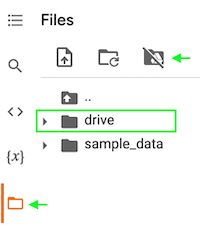

In [41]:
# Copy your data to your Google Drive
!cp -R /content/nmt/ /content/drive/MyDrive/